In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
# from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
d = 2
n = 1000
n_test = 100
sup = 1

In [5]:
def cov_matrix(cov_model, X_1, X_2, rho=1, a=0):
    return rho * np.nan_to_num(cov_model(cdist(X_1+a,X_2)), nan=1)

def K(X_1, X_2, cov_1, cov_2, cov_12, rho_12, a=0):
    aux = cov_matrix(cov_12, X_1, X_2, rho_12, a)
    return np.block([[cov_matrix(cov_1, X_1, X_1), aux], 
                     [aux.T, cov_matrix(cov_2, X_2, X_2)]])

def k(x, X_1, X_2, cov_1, cov_12, rho_12, a=0):
    return np.concatenate([cov_matrix(cov_1, x, X_1).T, cov_matrix(cov_12, x, X_2, rho_12, a).T])

In [6]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

Ejemplo de asimetría

In [7]:
a = np.array([[.3,.3]])

X_1 = np.array([[1,7], 
                [8,5],
                [4,3]])/10
X_2 = np.array([[3,7],
                [4,5]])/10

$a=0$

In [6]:
cov_matrix(matern_model(theta=2,nu=3/2),X_1,X_1,1,0)

array([[1.        , 0.57265089, 0.73575888],
       [0.57265089, 1.        , 0.77452087],
       [0.73575888, 0.77452087, 1.        ]])

$a\neq 0$

In [7]:
cov_matrix(matern_model(theta=2,nu=3/2),X_1,X_1,1,a)

array([[0.79125229, 0.63370268, 0.59183271],
       [0.40331261, 0.79125229, 0.4869167 ],
       [0.65665308, 0.96679942, 0.79125229]])

In [8]:
cov_matrix(matern_model(2,3/2),X_1,X_2,1,a)

array([[0.86730013, 0.73575888],
       [0.52091808, 0.55010579],
       [0.79991584, 0.86730013]])

In [9]:
cov_matrix(matern_model(2,3/2),X_2,X_1,1,-a)

array([[0.86730013, 0.52091808, 0.79991584],
       [0.73575888, 0.55010579, 0.86730013]])

In [10]:
K(X_1, X_2, matern_model(theta=2,nu=3/2), matern_model(theta=2,nu=3/2), matern_model(theta=2,nu=3/2), 1, a).round(3)

array([[1.   , 0.573, 0.736, 0.867, 0.736],
       [0.573, 1.   , 0.775, 0.521, 0.55 ],
       [0.736, 0.775, 1.   , 0.8  , 0.867],
       [0.867, 0.521, 0.8  , 1.   , 0.925],
       [0.736, 0.55 , 0.867, 0.925, 1.   ]])

Ejemplo traslación puntos por $a$.

In [11]:
X = gen_observation_points(d, 1000, sup)

a = np.array([[.3,.3]])

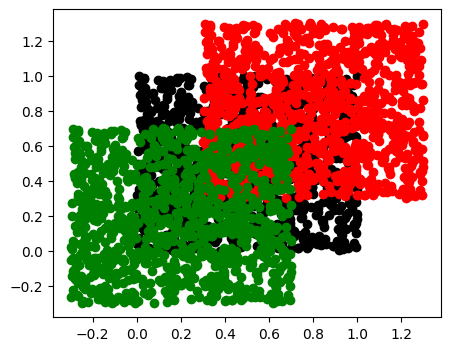

In [12]:
plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c='k')
plt.scatter((X+a)[:,0], (X+a)[:,1], c='r')
plt.scatter((X-a)[:,0], (X-a)[:,1], c='g');

In [8]:
nu_1 = 1/2
nu_2 = 1/2
theta_1 = 10
theta_2 = 8

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [9]:
X_1 = np.concatenate([gen_observation_points(d, n_test, .7),
                      gen_observation_points(d, n, sup)])
X_2 = gen_observation_points(d, n, sup)
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]

X_test, Y_test = X_1[:n_test], Y_1[:n_test]
X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
sigma = sigma[n_test:, :][:, n_test:]

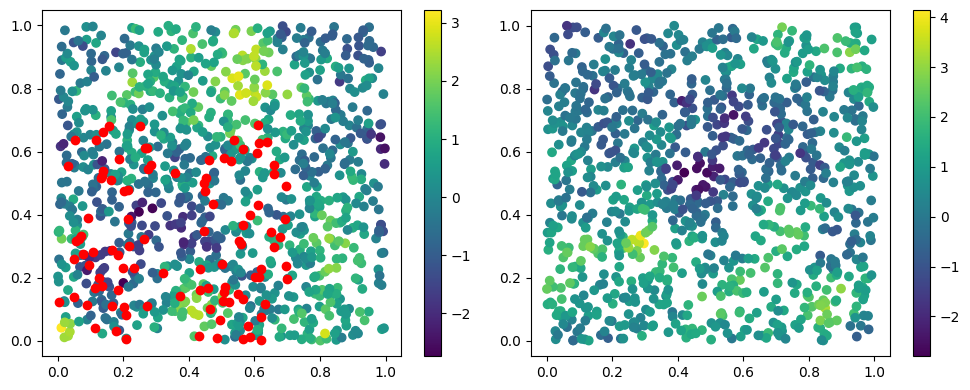

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

sc1 = ax1.scatter(X_1[:,0], X_1[:,1], c=Y_1)
fig.colorbar(sc1, ax=ax1)
ax1.scatter(X_test[:,0], X_test[:,1], c='r')
sc2 = ax2.scatter(X_2[:,0], X_2[:,1], c=Y_2)
fig.colorbar(sc2, ax=ax2)

fig.tight_layout();

In [11]:
class coKrigingNN:
    def __init__(self, X_1, X_2, Y_1, Y_2, N, cov_family, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a):
        check_consistent_dimension(1, X_1, X_2)
        check_consistent_dimension(0, X_1, Y_1)
        check_consistent_dimension(0, X_2, Y_2)
        # check_consistent_dimension(1, X_1, a)
        self.X_1, self.X_2 = X_1, X_2
        self.Y_1, self.Y_2 = Y_1, Y_2
        self.N = N
        self.cov_family = cov_family
        self.a = a
        
        check_positive_elements(theta_1, theta_2, theta_12, nu_1, nu_2, nu_12)
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_12 = theta_12
        self.nu_1 = nu_1
        self.nu_2 = nu_2
        self.nu_12 = nu_12
        self.rho_12 = rho_12
    
    def _predict(self, x):
        indexes_1 = N_nearest_observations_points(self.X_1, x, self.N)
        indexes_2 = N_nearest_observations_points(self.X_2, x, self.N)
        
        sigma = K(self.X_1[indexes_1], self.X_2[indexes_2],
                  self.cov_family(self.theta_1, self.nu_1),
                  self.cov_family(self.theta_2, self.nu_2),
                  self.cov_family(self.theta_12, self.nu_12),
                  self.rho_12, self.a)
        c = k(x, self.X_1[indexes_1], self.X_2[indexes_2],
              self.cov_family(self.theta_1, self.nu_1),
              self.cov_family(self.theta_12, self.nu_12),
              self.rho_12, self.a) 
        return c.T @ np.linalg.solve(sigma, np.concatenate([self.Y_1[indexes_1], self.Y_2[indexes_2]]))
    
    def predict(self, X):
        return np.array([self._predict(X[[i]]) for i in range(len(X))])

In [12]:
def co_kriging(x, X_1, X_2, Y_1, Y_2, cov_1, cov_12, rho_12, sigma, a=0):
    'si x es un conjunto de puntos, entrega las predicciones de Y_1'
    c = k(x, X_1, X_2, cov_1, cov_12, rho_12, a)   
    return c.T @ np.linalg.solve(sigma, np.concatenate([Y_1, Y_2]))

In [13]:
# sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)
Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
root_mean_squared_error(Y_test, Y_pred)

0.41738786288063245

In [14]:
N = 100
coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
Y_pred = coKNN.predict(X_test)
root_mean_squared_error(Y_test, Y_pred)

0.4574516944103655

In [15]:
from implementations import gen_As
import pandas as pd
import seaborn as sns

In [16]:
def K_ij(X_1_i, X_1_j, X_2_i, X_2_j, cov_1, cov_2, cov_12, rho_12, a):
    return np.block([[cov_matrix(cov_1, X_1_i, X_1_j), cov_matrix(cov_12, X_1_i, X_2_j, rho_12, a)], 
                     [cov_matrix(cov_12, X_2_i, X_1_j, rho_12, -a), cov_matrix(cov_2, X_2_i, X_2_j)]])

class NestedCoKriging:
    '''
    Queremos predecir observaciones de la variable Y_1 utilizando las obs. de ambas.
    '''
    def __init__(self, X_1, X_2, Y_1, Y_2, cov_family, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a=0):
        check_consistent_dimension(1, X_1, X_2)
        check_consistent_dimension(0, X_1, Y_1)
        check_consistent_dimension(0, X_2, Y_2)
        self.X_1, self.X_2 = X_1, X_2
        self.Y_1, self.Y_2 = Y_1, Y_2
        self.d = self.X_1.shape[1]
        self.n_1, self.n_2 = self.X_1.shape[0], self.X_2.shape[0]
        self.cov_family = cov_family
        self.a = a
        
        check_positive_elements(theta_1, theta_2, theta_12, nu_1, nu_2, nu_12)
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_12 = theta_12
        self.nu_1 = nu_1
        self.nu_2 = nu_2
        self.nu_12 = nu_12
        self.rho_12 = rho_12
        
         
        self.ZZZ = None
        
    def ncok(self, x, A_1=[], A_2=[], NN=False, n_clusters=None):
        check_consistent_dimension(0, A_1, A_2)

        Y = np.concatenate([self.Y_1, self.Y_2])
        if NN:
            indices_1 = N_nearest_observations_points(self.X_1, x, self.n_1)
            A_1 = indices_1[:(-(self.n_1%n_clusters) if self.n_1%n_clusters!=0 else self.n_1)].reshape((n_clusters, self.n_1//n_clusters)).tolist()
            A_1[-1] += indices_1[-(self.n_1%n_clusters):].tolist() if self.n_1%n_clusters!=0 else []

            indices_2 = N_nearest_observations_points(self.X_2, x, self.n_2)
            A_2 = indices_2[:(-(self.n_2%n_clusters) if self.n_2%n_clusters!=0 else self.n_2)].reshape((n_clusters, self.n_2//n_clusters)).tolist()
            A_2[-1] += indices_2[-(self.n_2%n_clusters):].tolist() if self.n_2%n_clusters!=0 else []

        A = [[x,y] for x,y in zip(A_1, A_2)]
        shift_n = self.n_1
        k_x_Xs = k(x, self.X_1, self.X_2, self.cov_family(self.theta_1, self.nu_1), self.cov_family(self.theta_12, self.nu_12), self.rho_12, self.a)
        
        
        lens_A = [sum(len(subsublist) for subsublist in sublist) for sublist in A]
        cumsum_lens_A = np.cumsum(lens_A)
        
        if self.ZZZ is None or NN:
            self.gen_big_matrix(A, lens_A, cumsum_lens_A)
        
        pivot, C = 0, np.zeros((sum(lens_A), len(A)))
    
        M = np.zeros((len(A), 1))
        
        for i in range(len(A)):
            indexes = A[i][0]+list(shift_n+np.array(A[i][1]))
            
            C[pivot:(pivot+lens_A[i]), [i]] = np.linalg.solve(self.ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])], k_x_Xs[indexes, :])
            
            M[i] = C[pivot:(pivot+lens_A[i]), [i]].T @ Y[indexes]
            
            pivot+=lens_A[i]
            
        # cov(M, M) = C.T @ ZZZ @ C
        # cov(M, Y) = diag(C.T @ ZZZ @ C)
        
        K_M = C.T @ self.ZZZ @ C
        return np.diag(K_M) @ np.linalg.solve(K_M, M)
    
    def gen_big_matrix(self, A, lens_A, cumsum_lens_A):
        row, self.ZZZ = 0, np.zeros((sum(lens_A), sum(lens_A)))
        for i in range(len(A)):
            column=cumsum_lens_A[i]
            for j in range(i+1, len(A)):
                self.ZZZ[row:(row+lens_A[i]), column:(column+lens_A[j])] = K_ij(self.X_1[A[i][0]], self.X_1[A[j][0]], 
                                                                                self.X_2[A[i][1]], self.X_2[A[j][1]],
                                                                                self.cov_family(self.theta_1, self.nu_1),
                                                                                self.cov_family(self.theta_2, self.nu_2),
                                                                                self.cov_family(self.theta_12, self.nu_12),
                                                                                self.rho_12, self.a)
                column+=lens_A[j]
            row+=lens_A[i]
        self.ZZZ += self.ZZZ.T
        pivot = 0
        for i in range(len(A)):
            self.ZZZ[pivot:(pivot+lens_A[i]), pivot:(pivot+lens_A[i])] = K_ij(self.X_1[A[i][0]], self.X_1[A[i][0]], 
                                                                              self.X_2[A[i][1]], self.X_2[A[i][1]],
                                                                              self.cov_family(self.theta_1, self.nu_1),
                                                                              self.cov_family(self.theta_2, self.nu_2),
                                                                              self.cov_family(self.theta_12, self.nu_12),
                                                                              self.rho_12, self.a)
            pivot+=lens_A[i]
    
    def predict(self, X_test, A_1=[], A_2=[], NN=False, n_clusters=None):
        check_consistent_dimension(0, A_1, A_2)
        return np.array([self.ncok(X_test[[i]], A_1, A_2, NN, n_clusters) for i in range(len(X_test))])

In [17]:
n_clusters = 20
A_1, A_2 = gen_As(X_1, X_2, n_clusters)
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_test, Y_pred)

0.4358617361735251

In [18]:
class prueba:
    def __init__(self, X_1, X_2, Y_1, Y_2, cov_family, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a=0):
        self.X_1, self.X_2 = X_1, X_2
        self.Y_1, self.Y_2 = Y_1, Y_2
        self.d = self.X_1.shape[1]
        self.n_1, self.n_2 = self.X_1.shape[0], self.X_2.shape[0]
        self.cov_family = cov_family
        self.a = a
        
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta_12 = theta_12
        self.nu_1 = nu_1
        self.nu_2 = nu_2
        self.nu_12 = nu_12
        self.rho_12 = rho_12
        
         
        self.sigma = None
        
    def ncok(self, x, A_1=[], A_2=[]):
        Y = np.concatenate([self.Y_1, self.Y_2])

        A = [[x,y] for x,y in zip(A_1, A_2)]
        shift_n = self.n_1
        k_x_Xs = k(x, self.X_1, self.X_2, self.cov_family(self.theta_1, self.nu_1), self.cov_family(self.theta_12, self.nu_12), self.rho_12, self.a)
        
        if self.sigma is None:
            self.sigma = K(self.X_1, self.X_2, 
                      self.cov_family(self.theta_1, self.nu_1), 
                      self.cov_family(self.theta_2, self.nu_2), 
                      self.cov_family(self.theta_12, self.nu_12), 
                      self.rho_12, self.a)
        
        M = np.zeros((len(A), 1))
        k_M = np.zeros((len(A), 1))
        K_M = np.zeros((len(A), len(A)))
        
        for i in range(len(A)):
            indexes_i = A[i][0]+list(shift_n+np.array(A[i][1]))
            aux_i = np.linalg.solve(self.sigma[indexes_i, :][:, indexes_i], k_x_Xs[indexes_i, :]) # ( k(x, X_i) @ k(X_i, X_i)^{-1} ).T
            M[i] = aux_i.T @ Y[indexes_i]
            k_M[i] = aux_i.T @ k_x_Xs[indexes_i, :]
            for j in range(i):                    
                indexes_j = A[j][0]+list(shift_n+np.array(A[j][1]))
                aux_j = np.linalg.solve(self.sigma[indexes_j, :][:, indexes_j], k_x_Xs[indexes_j, :]) # ( k(x, X_j) @ k(X_j, X_j)^{-1} ).T
                K_M[i,j] = aux_i.T @ self.sigma[indexes_i, :][:, indexes_j] @ aux_j
        K_M += K_M.T
        np.fill_diagonal(K_M, k_M)

        return k_M.T @ np.linalg.solve(K_M, M)
    
    def predict(self, X_test, A_1=[], A_2=[]):
        return np.array([self.ncok(X_test[[i]], A_1, A_2) for i in range(len(X_test))]).reshape(-1)

In [19]:
# pr = prueba(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
# Y_pred_prueba = pr.predict(X_test, A_1, A_2)

In [20]:
# root_mean_squared_error(Y_test, Y_pred), root_mean_squared_error(Y_test, Y_pred_prueba)

In [21]:
# root_mean_squared_error(Y_pred_prueba, Y_pred)

Datos isotopicos

In [26]:
results_isotopic = []
Ns = [10, 50, 100]
Ks = [100, 20, 10]

In [42]:
for _ in range(50):
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, .7), X_2])
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]

    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    results_isotopic.append(['coK', n, 1, root_mean_squared_error(Y_test, Y_pred)])

    for N in Ns:
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        results_isotopic.append(['coKNN', N, n//N, root_mean_squared_error(Y_test, Y_pred)])    
    
    for n_clusters in Ks:
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        results_isotopic.append(['NcoK', n//n_clusters, n_clusters, root_mean_squared_error(Y_test, Y_pred)])

In [43]:
df_isotopic = pd.DataFrame(results_isotopic, columns=['METHOD', 'N', 'K', 'RMSE'])

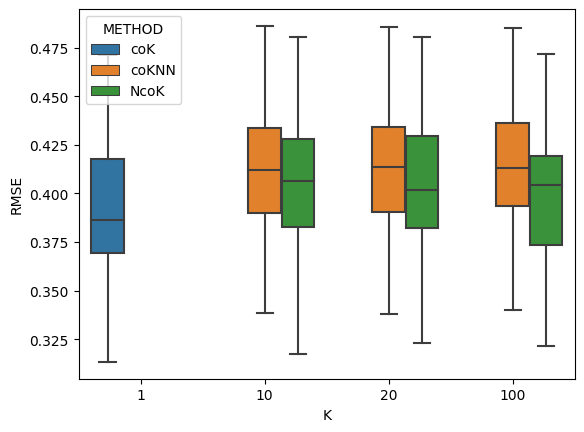

In [44]:
sns.boxplot(data=df_isotopic, x='K', y='RMSE', hue='METHOD');

Datos heterotopicos

In [45]:
results_heterotopic = []

In [46]:
for _ in range(50):
    X_1 = np.concatenate([gen_observation_points(d, n_test, .7), gen_observation_points(d, n, sup)])
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]

    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    results_heterotopic.append(['coK', n, 1, root_mean_squared_error(Y_test, Y_pred)])

    for N in Ns:
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        results_heterotopic.append(['coKNN', N, n//N, root_mean_squared_error(Y_test, Y_pred)])    
    
    for n_clusters in Ks:
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        results_heterotopic.append(['NcoK', n//n_clusters, n_clusters, root_mean_squared_error(Y_test, Y_pred)])

In [47]:
data_heterotopic = pd.DataFrame(results_heterotopic, columns=['METHOD', 'N', 'K', 'RMSE'])

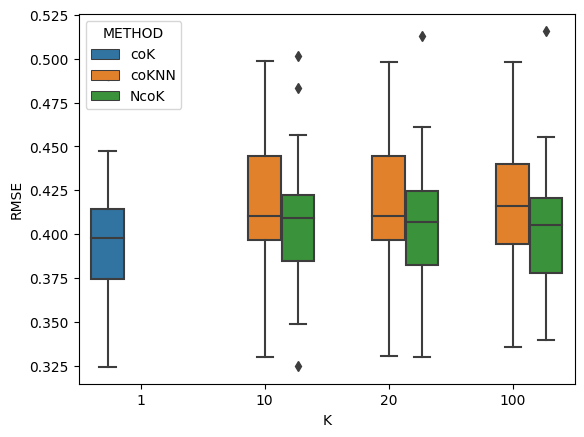

In [48]:
sns.boxplot(data=data_heterotopic, x='K', y='RMSE', hue='METHOD');

Datos isotopicos con $a=0$

In [31]:
results = []
a = 0

In [32]:
for _ in range(50):    
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, sup), X_2])
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]

    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    results.append(['coK', n, 1, root_mean_squared_error(Y_test, Y_pred)])

    for N in Ns:
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        results.append(['coKNN', N, n//N, root_mean_squared_error(Y_test, Y_pred)])    
    
    for n_clusters in Ks:
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        results.append(['NcoK', n//n_clusters, n_clusters, root_mean_squared_error(Y_test, Y_pred)])

In [33]:
data = pd.DataFrame(results, columns=['METHOD', 'N', 'K', 'RMSE'])

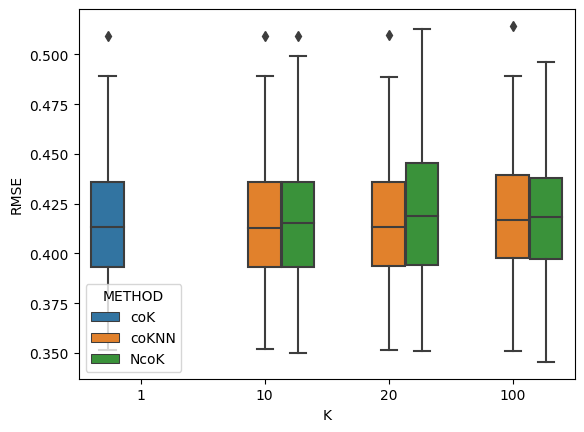

In [34]:
sns.boxplot(data=data, x='K', y='RMSE', hue='METHOD');